In [1]:
import networkx as nx
import matplotlib.pyplot as plt   
import numpy as np

In [2]:
class NFA:
    def __init__(self,file):
        # Initializing the list of adjancy tuples for NFA 
        self.adj_tuple = list() 
        
        # Reading the Prodcution rule/ derivation rules
        Lines =  open(file, 'r').readlines()  
        
        # replacing the \n
        for i in range (len(Lines)):
             Lines[i] = Lines[i].replace('\n','') 

        # Getting the transitions 
        for i in range(len(Lines)):
            if '(q0' in Lines[i]:
                index = i
                break  
        # Updating the Lines starting from transitions
        Lines = Lines[index:] 

        
        # Updating the tuples 
        for line in Lines:
            source_state = line[ line.index('q') : line.index('q') + 2]  
            terminal =  line[ line.index(',') + 1 : line.index(')')]  
            dest_state =  line[ line.index('=')  + 1 :].replace(',',"").replace(' ',"").replace('.',"") 
            
            # Adding all the data 
            self.adj_tuple.append( (( source_state,terminal ),dest_state))  
    
    def plot(self): 
        
        G = nx.DiGraph()  
        edges = list() 
        labels = dict() 
        
        for state_tup in self.adj_tuple:  

            # state_tup[0] = (source_state, terminal) 
            # state_tup[1] = dest_state

            # adding the source_state and dest_state
            edges.append( (state_tup[0][0] ,state_tup[1]) )   

            # if  the source_state and dest_state  exist already, it just updates the terminal symbols with ','.
            if (state_tup[0][0], state_tup[1])  in labels.keys():
                labels[ (state_tup[0][0], state_tup[1]) ] = labels[ (state_tup[0][0], state_tup[1]) ] + "," + state_tup[0][1]  

            #else it would updated the dictionary with  ( source_state, dest_state) : terminal . 
            else:
                labels[(state_tup[0][0], state_tup[1])] = state_tup[0][1] 


        # Plotting stuff
        G.add_edges_from(edges)
        # Need to create a layout when doing
        # separate calls to draw nodes and edges
        pos = nx.spring_layout(G) 
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=20)  
        nx.draw_networkx_labels(G, pos) 
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='b', arrows=True)      
        nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                               node_color = 'yellow', node_size = 300)  
        plt.rcParams["figure.figsize"] = (20,10)
        plt.title('NFA')
        plt.show()  


In [3]:
class DFA:
    def __init__(self,nfa_tups):
        self.nfa = nfa_tups 
        self.dfa = list() 
    
    def sort_states(self,tup): 

        # tup[0] =  (source_state,terminal)  
        #tup[1] = dest_states  

        # Sorting work with tup[1] :  of i > 2 : Example :  'q2q1' => 'q1q2'


        temp_arr = list() 
        for i in range(  len(tup[1]) ):
            if i%2 != 0:
                temp_arr.append(int(tup[1][i]))  

        temp_arr.sort() 
        temp_arr = np.unique(temp_arr)
        tup[1] = ''
        for x in temp_arr:
            tup[1] =  tup[1] + f'q{x}' 
        return tup[1]  
    
    
    
    def get_transition_tuples(self,cur_state):
        

        # If the given state is of a form 'q1q2' 
        if len(cur_state) > 2: 

            temp_transitions = list() 
            z = 0  

            # parsing each state from the group of states and getting their possible transitions
            for i in range(len(cur_state)):  
                # ODD NUMBERS  from states represents the actual state's number. Example: selecting 'q1' and 'q2' from state 'q1q2' 
                # z index is just addition iterative var to help to delimit states from a whole string state. 

                # Taking the states one by one.
                if (i+1)%2 == 0:
                    #print(cur_state[z:i+1])  

                    # Recursively calling the below code for single state transitions
                    result = self.get_transition_tuples(cur_state[z:i+1])   

                    # Updating the  transitions 
                    for res in result: 
                        temp_transitions.append( [ [cur_state, res[0][1]] ,res[1]] )   

                    # Updating the state from the string.
                    z+=2 



            temp_final = list() 

            # Cleaning the transitions and forming new states in case the terminal symbols matches.
            for x in temp_transitions:
                bool_append = True

                for y in temp_final:
                    # In case of matching terminal symbols.
                    if x[0] == y[0]:
                        y[1] = y[1] + x[1]  
                        y[1] = self.sort_states(y) 

                        bool_append =False 
                        continue 

                if bool_append:
                    temp_final.append(x)  

            # Converting the temo_final array type to a tuple ((source_state, terminal), dest_state)      
            final_tuple = list()
            for x in temp_final:
                final_tuple.append(  ((x[0][0],x[0][1]),x[1]))
            return final_tuple 



        # ELSE: 
        # For a single state,  EXAMPLE : 'q1' 

        single_state_tuple = list()   
        possible_transitions = list() 
        # Searching for possible transitions for the current state. Just for a single state. 
        for tup in self.nfa: 

            # if the current states matches the state in adj_tuple 
            if cur_state == tup[0][0]: 

                # 1st transitions found.
                if len(possible_transitions) == 0: 
                     possible_transitions.append( [tup[0][1],tup[1]] )  

                # Updating the checking the transitions tuple 
                for way in possible_transitions:  
                    #if   transition have the same terminal transition symbol 
                    if tup[0][1] == way[0]:   
                        # it add the state to the current state string
                        way[1] = way[1] + tup[1] 
                        # sorts the current state string: 
                        way[1] = self.sort_states(way) 
                    # If the transitions symbol is different
                    else:
                        possible_transitions.append( [tup[0][1],tup[1]] )  

        # Converting arrays to tuples  
        for x in possible_transitions:
            single_state_tuple.append(  ((cur_state, x[0]), x[1]) )  

        return single_state_tuple 
    
    
    def convert_to_DFA(self):
        isNotEmpty = True   
        state_stack = ['q0']
        index_stack = 0 
        prev_index  = -1 

        while isNotEmpty:

            # Stopping Criterion. In case of not having new states.
            if prev_index == index_stack:
                isNotEmpty = False 

            # Changing the states as they automatically adds to the stack
            current_state = state_stack[index_stack]  

            # a helpful stopping criterion var. 
            prev_index = index_stack 

            # getting the list of tuples for a state
            state_trans = self.get_transition_tuples(current_state)   
            for x in state_trans: 

                if x not in self.dfa: 
                    self.dfa.append(x) 

                    # If the dest_state was not parsed yet: it adds it to the stack and the index is updated.
                    if x[1] not in state_stack:
                        state_stack.append(x[1]) 
                        index_stack+=1 
                

    
    def plot(self):
        G = nx.DiGraph()  
        edges = list() 
        labels = dict() 
        for state_tup in self.dfa:  

            # state_tup[0] = (source_state, terminal) 
            # state_tup[1] = dest_state

            # adding the source_state and dest_state
            edges.append( (state_tup[0][0] ,state_tup[1]) )   

            # if  the source_state and dest_state  exist already, it just updates the terminal symbols with ','.
            if (state_tup[0][0], state_tup[1])  in labels.keys():
                labels[ (state_tup[0][0], state_tup[1]) ] = labels[ (state_tup[0][0], state_tup[1]) ] + "," + state_tup[0][1]  

            #else it would updated the dictionary with  ( source_state, dest_state) : terminal . 
            else:
                labels[(state_tup[0][0], state_tup[1])] = state_tup[0][1] 



        G.add_edges_from(edges)
        # Need to create a layout when doing
        # separate calls to draw nodes and edges
        pos = nx.spring_layout(G) 



        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=20)  




        nx.draw_networkx_labels(G, pos) 

        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='b', arrows=True)      

        nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                               node_color = 'yellow', node_size = 300)  



        plt.rcParams["figure.figsize"] = (20,10)
        plt.title('FA')
        plt.show() 
    
    
    
    

    
    
        

In [4]:
nfa_obj = NFA('NFA.txt') 

In [5]:
nfa_obj.adj_tuple

[(('q0', 'a'), 'q1'),
 (('q1', 'b'), 'q2'),
 (('q2', 'c'), 'q0'),
 (('q1', 'b'), 'q3'),
 (('q3', 'a'), 'q4'),
 (('q3', 'b'), 'q0')]

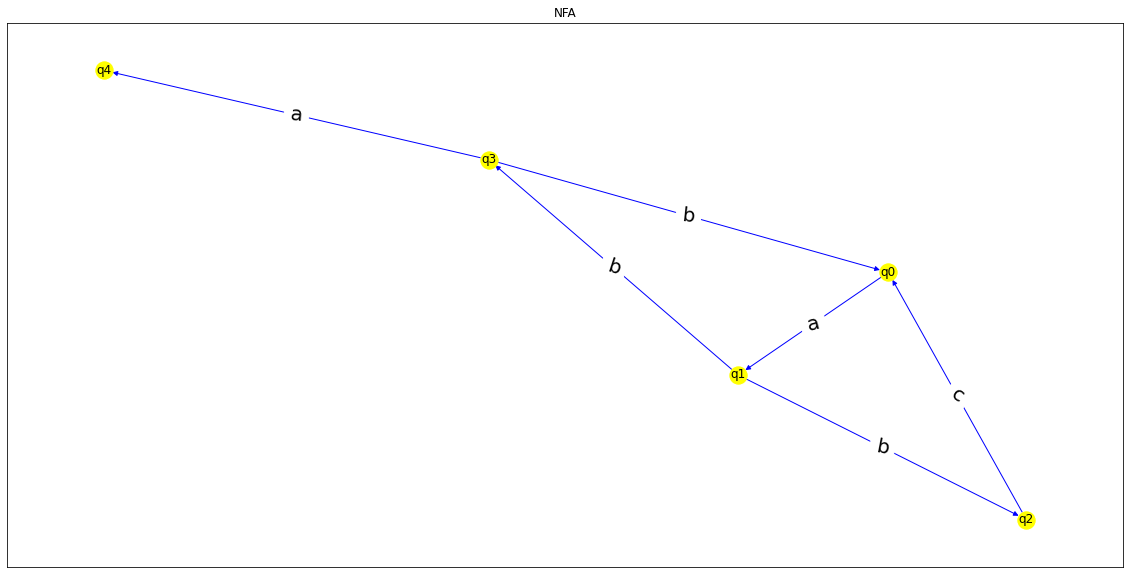

In [11]:
nfa_obj.plot()

In [7]:
dfa_obj = DFA(nfa_obj.adj_tuple)

In [8]:
dfa_obj.convert_to_DFA()

In [9]:
dfa_obj.dfa

[(('q0', 'a'), 'q1'),
 (('q1', 'b'), 'q2q3'),
 (('q2q3', 'c'), 'q0'),
 (('q2q3', 'a'), 'q4'),
 (('q2q3', 'b'), 'q0')]

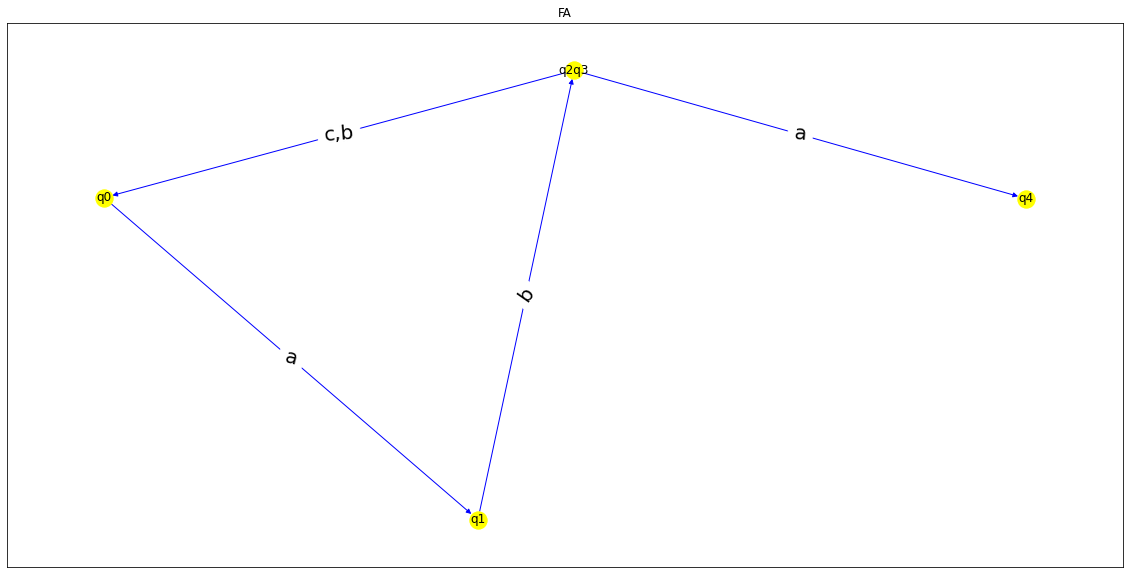

In [10]:
dfa_obj.plot()